# Introducción

Insideairbnb.com es un sitio web en el que se publican conjuntos de datos extraídos de la web de "instantáneas" de ciudades. He descargado los archivos de Hawaii de la situación del 6 de diciembre de 2018. Pensé que era un conjunto de datos divertido para asumir. Además de la disputa de datos básicos y las tramas, también he agregado **mapas interactivos de Folium, gráficos interactivos de tramas y extracción de texto de los comentarios de revisión.**


<br>
<center><img src="https://imgur.com/qrVfcpS.png"></center>
<br>


# 1. Importando módulos y datos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

## 1.3 Detalles del listado de viviendas

El conjunto de datos contiene un total de 7 archivos. El archivo de listados es un archivo de descripción general que las etiquetas internas de airbnb como "bueno para visualizaciones". El identificador único en el conjunto de datos es la identificación de "listings". Esta es básicamente la identificación del anuncio. En general, había 34049 listados de Airbnb en Hawai desde 2018.

In [2]:
listings = pd.read_csv("listings.csv", index_col= "id")
listings_details = pd.read_csv("listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("reviews_details.csv", parse_dates=['date'])

C:\Users\User\AppData\Local\Temp\ipykernel_28808\1155226019.py:4: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
print(listings.shape)

(34049, 17)


El archivo de listados contiene 17 variables por listado además del id.

In [4]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

El archivo listings contiene un total de 96 variables. No vamos a usar todos estos, sino que juntaremos selectivamente una serie de variables que parecen útiles para este EDA.

In [5]:
listings.head()

name  \
id                                                                      
34421962                                   Waipouli Beach Resort E106   
40707945                     DO NOT PUBLISH BEFORE MERGING 14891-HROV   
43656551              Ilikai 1212 Ocean / Lagoon / King Bed, Sofa Bed   
39096262                                          $900 rooms for rent   
735005738415289686  The Point at Poipu, a Hilton Vacation Club, Kauai   

                      host_id                  host_name neighbourhood_group  \
id                                                                             
34421962             34386367               Kauai Calls!               Kauai   
40707945            182704096  Aston Waikiki Beach Hotel            Honolulu   
43656551            347952914            Hawaii Vacation            Honolulu   
39096262            299657655                    Chelsea            Honolulu   
735005738415289686   24157156                      David               Kauai   

                           neighbourhood   latitude   longitude  \
id                                                                
34421962                    Kapaa-Wailua  22.062280 -159.319180   
40707945            Primary Urban Center  21.272438 -157.822556   
43656551            Primary Urban Center  21.284374 -157.838440   
39096262            Primary Urban Center  21.340290 -157.878160   
735005738415289686           Koloa-Poipu  21.870674 -159.441671   

                          room_type  price  minimum_nights  number_of_reviews  \
id                                                                              
34421962            Entire home/apt  417.0               1                  0   
40707945               Private room  290.0               1                  0   
43656551            Entire home/apt  199.0               1                 52   
39096262               Private room    NaN             365                  0   
735005738415289686     Private room    NaN               7                  0   

                   last_review  reviews_per_month  \
id                                                  
34421962                   NaN                NaN   
40707945                   NaN                NaN   
43656551            2024-02-20               1.51   
39096262                   NaN                NaN   
735005738415289686         NaN                NaN   

                    calculated_host_listings_count  availability_365  \
id                                                                     
34421962                                        41               243   
40707945                                         9               365   
43656551                                        79               145   
39096262                                         1                 0   
735005738415289686                               1               353   

                    number_of_reviews_ltm                           license  
id                                                                           
34421962                                0                      430080010111  
40707945                                0                               NaN  
43656551                               13                            Exempt  
39096262                                0                               NaN  
735005738415289686                      0  280210001000, TA-124-323-5840-01

In [3]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34049 entries, 34421962 to 891631866049506737
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            34049 non-null  object 
 1   host_id                         34049 non-null  int64  
 2   host_name                       34047 non-null  object 
 3   neighbourhood_group             34049 non-null  object 
 4   neighbourhood                   34049 non-null  object 
 5   latitude                        34049 non-null  float64
 6   longitude                       34049 non-null  float64
 7   room_type                       34049 non-null  object 
 8   price                           30985 non-null  float64
 9   minimum_nights                  34049 non-null  int64  
 10  number_of_reviews               34049 non-null  int64  
 11  last_review                     26138 non-null  object 
 12  reviews_per_month

In [4]:
listings_copy = listings.copy()
listings = listings.drop(columns=['neighbourhood_group'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))
listings.head()

name  \
id                                                                      
34421962                                   Waipouli Beach Resort E106   
40707945                     DO NOT PUBLISH BEFORE MERGING 14891-HROV   
43656551              Ilikai 1212 Ocean / Lagoon / King Bed, Sofa Bed   
39096262                                          $900 rooms for rent   
735005738415289686  The Point at Poipu, a Hilton Vacation Club, Kauai   

                      host_id                  host_name  \
id                                                         
34421962             34386367               Kauai Calls!   
40707945            182704096  Aston Waikiki Beach Hotel   
43656551            347952914            Hawaii Vacation   
39096262            299657655                    Chelsea   
735005738415289686   24157156                      David   

                           neighbourhood   latitude   longitude  \
id                                                                
34421962                    Kapaa-Wailua  22.062280 -159.319180   
40707945            Primary Urban Center  21.272438 -157.822556   
43656551            Primary Urban Center  21.284374 -157.838440   
39096262            Primary Urban Center  21.340290 -157.878160   
735005738415289686           Koloa-Poipu  21.870674 -159.441671   

                          room_type  price  minimum_nights  number_of_reviews  \
id                                                                              
34421962            Entire home/apt  417.0               1                  0   
40707945               Private room  290.0               1                  0   
43656551            Entire home/apt  199.0               1                 52   
39096262               Private room    NaN             365                  0   
735005738415289686     Private room    NaN               7                  0   

                    ... review_scores_accuracy  review_scores_communication  \
id                  ...                                                       
34421962            ...                    NaN                          NaN   
40707945            ...                    NaN                          NaN   
43656551            ...                   4.67                         4.63   
39096262            ...                    NaN                          NaN   
735005738415289686  ...                    NaN                          NaN   

                    review_scores_checkin  review_scores_rating  \
id                                                                
34421962                              NaN                   NaN   
40707945                              NaN                   NaN   
43656551                             4.79                   4.6   
39096262                              NaN                   NaN   
735005738415289686                    NaN                   NaN   

                    maximum_nights  \
id                                   
34421962                      1125   
40707945                        28   
43656551                      1125   
39096262                       365   
735005738415289686             365   

                                                        listing_url  \
id                                                                    
34421962                      https://www.airbnb.com/rooms/34421962   
40707945                      https://www.airbnb.com/rooms/40707945   
43656551                      https://www.airbnb.com/rooms/43656551   
39096262                      https://www.airbnb.com/rooms/39096262   
735005738415289686  https://www.airbnb.com/rooms/735005738415289686   

                   host_is_superhost  \
id                                     
34421962                           f   
40707945                           f   
43656551                           f   
39096262                           f   
735005738415289686                 f   

                        

# 2. Análisis exploratorio
## 2.1 Vecindario

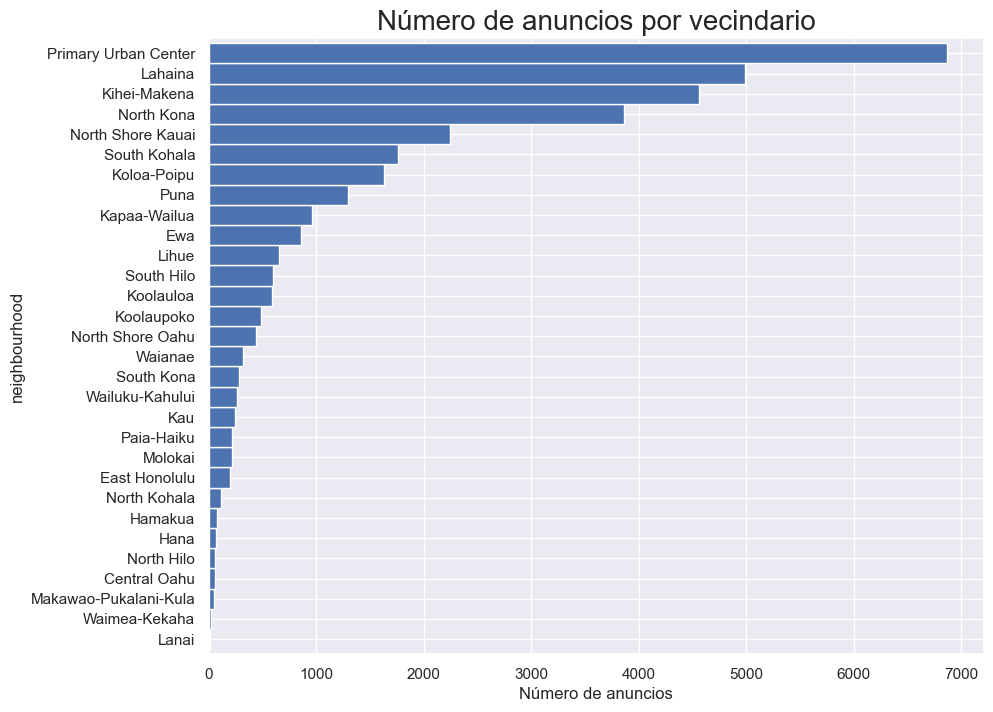

In [5]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Número de anuncios por vecindario", fontsize=20)
plt.xlabel('Número de anuncios', fontsize=12)
plt.show()

A continuación, se puede ver que la mayoría de los listados están distribuidos por las principales islas de Hawaii. Este mapa es interactivo y puede ampliar los grupos para encontrar las ubicaciones individuales de los listados.


In [6]:
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[20.7967, -156.3319], zoom_start=7)
FastMarkerCluster(data=locations).add_to(map1)
map1
#map1.save('map1.html')


## 2.2 Tipos de propiedades y habitaciones

### 2.2.1 Tipos de habitaciones

Las regulaciones sobre los tipos de habitaciones en alquiler a través de plataformas como Airbnb pueden tener un impacto significativo en el mercado de alquiler a corto plazo en Hawaii. En Oahu, se aplica una regulación estricta sobre los alquileres a corto plazo. La mayoría de las áreas residenciales están prohibidas para alquileres de menos de 30 días, a menos que el propietario tenga un permiso de Bed and Breakfast (B&B) o una Unidad Transitoria (STU). Estos permisos son limitados y están sujetos a ciertos requisitos, incluidos límites de ocupación y otras condiciones.

En Hawaii, los tipos de habitaciones disponibles en Airbnb generalmente se clasifican en cuatro categorías principales:

1. Casa/Apartamento completo: Una propiedad entera donde los huéspedes tienen acceso exclusivo a todas las instalaciones y áreas de la vivienda.

2. Habitación privada: Una habitación privada dentro de una vivienda compartida, donde los huéspedes comparten algunas áreas comunes con los anfitriones o con otros huéspedes.

3. Habitación de hotel: Habitación dentro de un hotel. (estándar, Deluxe, Suite, Ejecutiva o Familiar)

4. Habitación compartida: Un espacio compartido dentro de una vivienda donde los huéspedes comparten la habitación con otras personas.

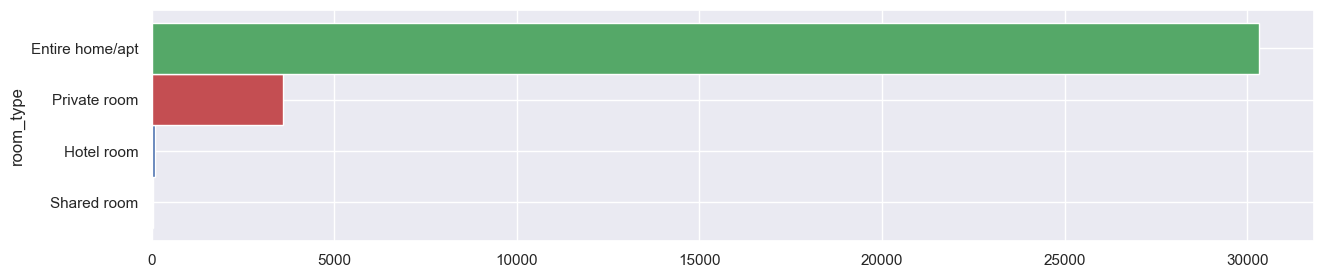

In [7]:
freq = listings['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r"])
plt.show()

### 2.2.2 Tipos de propiedades

En el conjunto de datos, encontramos muchos tipos de propiedades diferentes.

In [8]:
listings.property_type.unique()

array(['Entire condo', 'Room in hotel', 'Private room in home',
       'Shared room in home', 'Entire rental unit',
       'Private room in bed and breakfast', 'Entire home',
       'Private room in farm stay', 'Camper/RV', 'Room in boutique hotel',
       'Entire guesthouse', 'Entire cottage', 'Entire villa',
       'Entire home/apt', 'Entire serviced apartment', 'Dome',
       'Entire place', 'Entire guest suite', 'Private room in resort',
       'Entire townhouse', 'Entire cabin', 'Room in aparthotel',
       'Campsite', 'Entire vacation home',
       'Private room in serviced apartment', 'Room in resort',
       'Private room in condo', 'Tent', 'Private room',
       'Private room in rental unit', 'Entire bungalow',
       'Private room in guest suite', 'Tiny home',
       'Private room in cabin', 'Treehouse', 'Private room in guesthouse',
       'Private room in hostel', 'Private room in nature lodge',
       'Private room in barn', 'Farm stay', 'Entire loft',
       'Private room

Sin embargo, muchos de esos tipos de propiedades tienen muy pocos listados en Hawaii. En la figura a continuación, solo mostramos los tipos de propiedades con al menos 100 listados. Como podemos ver, la gran mayoría de las propiedades en Hawaii son Condominios completos seguidos de las unidades de alquiler completas y las casas completas.

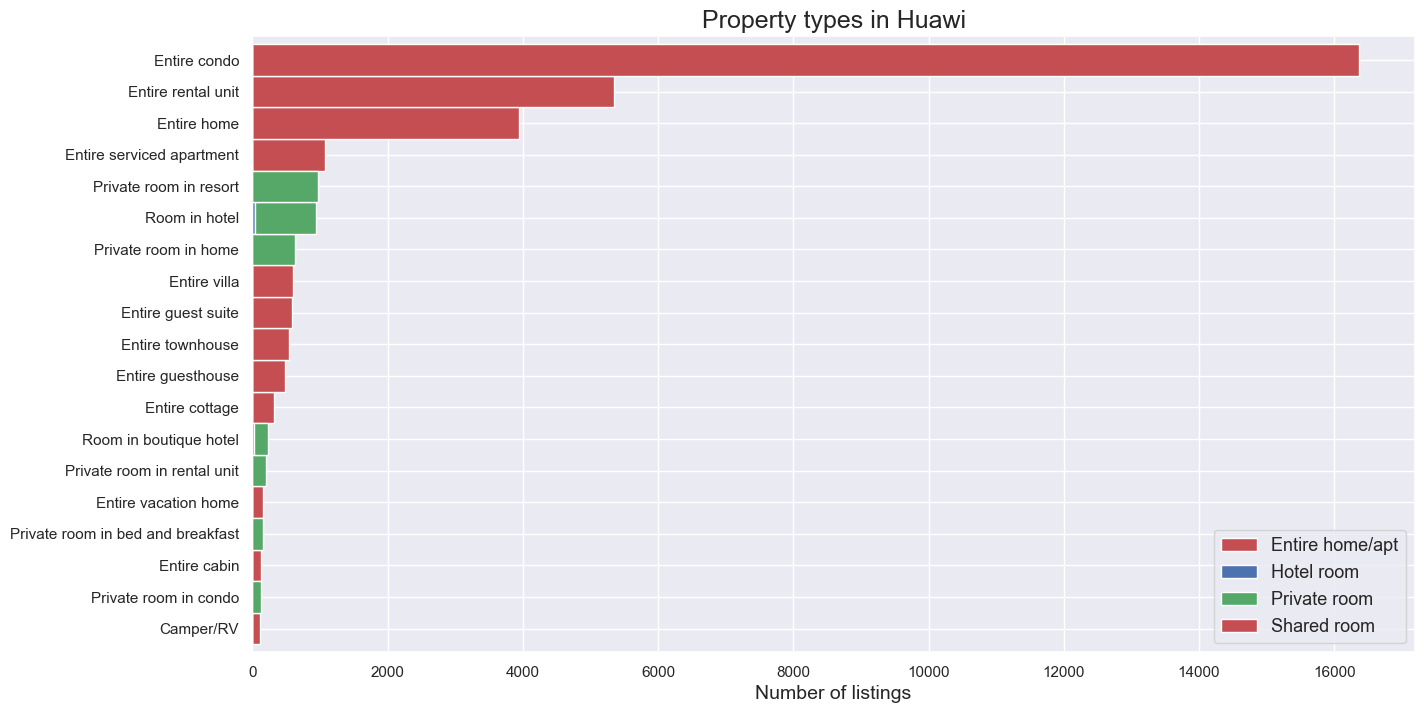

In [9]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Huawi', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

## 2.3 Número de alojados

Sorprendentemente, la mayoría de los listados son para 4 personas. Además, Airbnb utiliza un máximo de 16 huéspedes por anuncio.

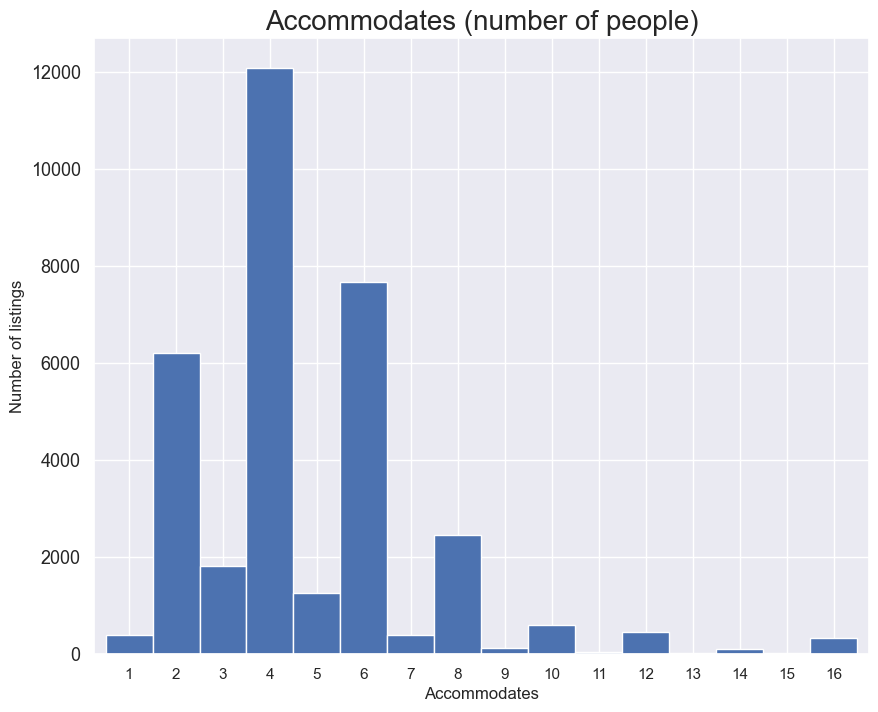

In [10]:
feq=listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

Cada isla y condado en Hawaii puede tener regulaciones específicas sobre el número máximo de personas permitidas en los alquileres a corto plazo.

Por lo general, se establece un límite máximo de personas basado en la capacidad de la propiedad y las regulaciones de seguridad.

# 3. Analítica al servicio del gobierno

Hawaii tiene regulaciones diferentes de un condado a otro, y todas ellas están diseñadas para limitar el número de propiedades en alquiler. (https://www.hostaway.com/blog/airbnb-rules-in-hawaii/)

El condado de Hawai adoptó el nuevo proyecto de ley 108 en noviembre de 2018. Mientras que ahora, en virtud de la Regla 23, todos los propietarios de alquiler a corto plazo están obligados a registrar su propiedad, incluyendo una cuota no reembolsable de $500.

Los establecidos antes del 1 de abril de 2019, todavía están obligados a solicitar un Certificado de Uso Inconformado con una cuota anual de renovación de $250, por la nueva regla. En adelante, los establecimientos sólo están permitidos en algunos distritos.

Adicionalmente, existen unas condiciones extras, en virtud de la nueva ordenanza 2018-114 que incluye un horario tranquilo de 9 pm a 8 am, los vehículos invitados sólo pueden ser estacionados en las zonas de aparcamiento designadas...

1. Condado de Honolulu

Solo reconoce dos tipos de alojamientos, los Bed & Breakfast, en el que el propietario está presente durante la estancia de los huéspedes (Max 4 huéspedes), y Transient Vacation Unit, donde el anfitrión alquila toda la casa y por lo tanto no está viviendo durante la estancia.

El 25 de junio de 2019, el proyecto de ley 89 del condado de Honolulu sentó las bases para una implementación más estricta que incluye: prohibido fuera de los distritos turísticos con la exención del Certificado de Uso Inconforme, o la publicidad ilegal será multada con hasta $10,000.

2. Condado de Maui

Las reglas y permisos en el Condado de Maui varían para cada tipo de hogar: B&B y casas de alquiler a corto plazo. A partir de julio de 2019, más de 16.000 unidades son legalmente eleg subvencionables para operar como alquiler a corto plazo durante menos de seis meses y sin necesidad de un permiso de B&B o permiso condicional. Sin embargo, la zona de Maui Meadows del Plan Comunitario de Kihei-Makena y la Región del Plan Comunitario Paia-Haiku ha alcanzado su tope para los permisos de alquiler a corto plazo y Airbnb, a partir de junio de 2021.

Además, los permisos concedidos para viviendas de alquiler a corto plazo se pueden alquilar sin la presencia del propietario. Para ser un Hogar de Alquiler a Corto Plazo, una aplicación completa a través del Departamento de Planificación del Condado de Maui es una necesidad que incluye un Formulario de Confirmación de Zoning y Diluvios que típicamente toma varios meses para que la solicitud se procese.

3. Condado de Kauai

El condado de Kauai cumple con sus propias regulaciones estrictas que de hecho ya no permiten legalmente alquileres a corto plazo fuera de las áreas de destino de visitantes permitidas (VDA) o distritos que están zonificados para hoteles. Aunque, si puede tenerlo si usted obtuvo un Certificado de Uso Inconforme antes de marzo de 2008 para su alquiler a corto plazo.

Para simplificar, los alquileres a corto plazo en Kauai no están permitidos por menos de 180 días de una habitación dentro de una casa, o una casa entera o apartamento en sí. Además, para ser un anfitrión de Airbnb en Kauai, no hay ninguna solicitud para aplicar si usted no tiene un alquiler a corto plazo en un VDA.

## 3.1 Encontrando potenciales hoteles ilegales

Dado todo lo anterior, en esta sección vamos a ver algunos casos extremos.

A continuación, mostramos los cinco anfitriones que tienen la mayor cantidad de listas de salas privadas. Desafortunadamente, Airbnb no proporciona las direcciones de los listados. 

In [11]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()
#host_private.to_csv("host_private.csv")
#private.to_csv("private.csv")

host_id  host_name  private_rooms
1089  468914400  RoomPicks             79
1172  501999278  RoomPicks             77
954   373168709       Mick             58
949   366621778    Robello             57
919   326084746  Suiteness             54

Sin embargo, tenemos las coordenadas GPS de los listados. Por ello, parece muy probable que todas las habitaciones privadas que ofrece Feliciano estén en el mismo edificio (solo variaciones menores en latitud/longitud). 

Aunque este anfitrión podría tener una licencia de hotel, sus listados también parecen sospechosos (¿cuál es el nombre del hotel?). Aconsejaría al municipio de Amsterdam que compruebe si no se infringen las normas en este caso.

In [12]:
roompicks = private[private['host_id']== 468914400]
roompicks = roompicks[['name','host_id', 'host_name', 'latitude', 'longitude']]
roompicks.index.name = "listing_id"
roompicks

name  \
listing_id                                                               
816787704238749048    Three Spacious Units! Close to Everything | Pool   
816788308042987282   Steps Away from the Sand! 3 Units w/ Balcony |...   
816641282839225697         Step in Your Balcony w/ Stunning View! Pool   
816786938006573213     Walk to Beach! 3 Suites w/ Stunning View | Pool   
767469258496319851            Convenient Location! Pool, Pets Allowed!   
...                                                                ...   
1101013963189177212   3 Comfortable Units! Outdoor Pool, Dogs Allowed!   
1101018577000891055  Dog-friendly Waikiki Hotel! 2 Units w/ Own Lanai!   
820228616939141427   Relax and Recharge! 3 Rooms w/ Lanai | Near Beach   
820251422325041479   Prime Location! Close to Everything | Pool Access   
820239650480696290   Relax & Unwind! 2 Pool View Accommodations, Lanai   

                       host_id  host_name   latitude   longitude  
listing_id                                                        
816787704238749048   468914400  RoomPicks  22.055372 -159.326246  
816788308042987282   468914400  RoomPicks  22.055330 -159.326208  
816641282839225697   468914400  RoomPicks  22.057217 -159.324621  
816786938006573213   468914400  RoomPicks  22.055118 -159.324851  
767469258496319851   468914400  RoomPicks  20.889410 -156.473110  
...                        ...        ...        ...         ...  
1101013963189177212  468914400  RoomPicks  21.279372 -157.825906  
1101018577000891055  468914400  RoomPicks  21.280620 -157.825670  
820228616939141427   468914400  RoomPicks  21.278883 -157.824388  
820251422325041479   468914400  RoomPicks  21.279640 -157.823861  
820239650480696290   468914400  RoomPicks  21.279221 -157.824011  

[79 rows x 5 columns]

## 3.2 Efectos no deseados de los anfitriones profesionales?

Hawaii cuenta con las reglas vigentes que comentamos anteriormente. Puedo imaginar que tener la opción de subcontratar estas actividades lleva a más listados. Por el momento, la mayoría de los anfitriones (6303) tienen solo un listado en la plataforma. Un número menor (1453) tienen dos listado, y auún menos (549) tienen tres listados. 

Existen casos extremos donde algunos anfitriones tienen un número muy alto de listados. (Tenemos un anftrión con 488 listados), lo que indica que son claramente profesionales o empresas de gestión de propiedades.

Dado que alrededor del 75% de los anfitriones tienen solo uno o dos listados, cualquier regulación debería tener en cuenta que la mayoría de los anfitriones no están operando a gran escala, por lo que las políticas deberían enfocarse en los casos extremos para evitar que los gestores profesionales dominen el mercado, asegurando así un acceso justo a la vivienda y limitando posibles abusos o excesos en la plataforma de alquileres a corto plazo.

Por último, debido a la dificultad de implementar y controlar una medida que prohíba por completo las actividades de alojamiento profesional, es recomendable que el municipio considere políticas que permitan un equilibrio entre los propietarios individuales y los gestores profesionales.
Esto podría incluir límites en el número de propiedades que un solo anfitrión puede listar o regulaciones adicionales para los anfitriones con múltiples propiedades.

In [13]:
freq = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop
#freq.to_csv("freq.csv")

num_host_listings   1     2    3    4    5    6    7    8    9    10   ...  \
count              6303  1453  549  288  151   84   71   50   40   25  ...   

num_host_listings  252  274  284  303  306  332  361  401  433  488  
count                1    1    1    1    1    1    1    1    1    1  

[1 rows x 121 columns]

A continuación, mostramos los anfitriones con más de 20 listados. Desafortunadamente, host_about no se raspa completamente. Sin embargo, como este conjunto de datos es extremadamente reciente, no fue difícil para mí encontrar la descripción del host con más de 200 listados en airbnb.com. Como puede ver, ¡este anfitrión es claramente un anfitrión profesional!

Como probablemente sea difícil implementar y controlar una medida que prohíba por completo las actividades de alojamiento profesional, recomendaría al municipio de Maui que considerara establecer un número máximo de listados por host. Si Hawaii estableciera esto en, por ejemplo, 10 (y logra que esto se implemente en los sistemas de Airbnb), sería mucho más difícil explotar el hospedaje en Airbnb como una actividad profesional.

In [14]:
freq = listings.groupby(['host_id', 'host_name', 'host_about']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings'] >= 20]
freq
#freq.to_csv("freq2.csv")

host_id              host_name  \
2132   39073224    Maui Resort Rentals   
3183  107293305                 Gather   
3448  132087088             Maui Condo   
3256  113441705       My Perfect Stays   
4096  231330348  Coral Tree Residences   
...         ...                    ...   
2000   34009334                 Makani   
1878   29961526                   Lisa   
2212   42947939                  Chris   
2603   60832928  Bija With Nomad Group   
2449   52896140                  Jason   

                                             host_about  num_host_listings  
2132  The Ohana (Family) at Maui Resort Rentals has ...                488  
3183  Gather with us! Gather Vacation Rentals is the...                433  
3448  At Maui Condo and Home, LLC we continue to ser...                401  
3256  My Perfect Stays is here to make your Maui vac...                332  
4096  Welcoming visitors to the Hawaiin islands for ...                306  
...                                                 ...                ...  
2000  Aloha, We are a small group of oceanfront cond...                 20  
1878  Aloha, I'm Lisa!! I am the owner of Stay Kauai...                 20  
2212  Aloha!\r\nI Love traveling and meeting new peo...                 20  
2603  A traveler and world adventurer from Californi...                 20  
2449  Over the years I picked up several timeshares ...                 20  

[177 rows x 4 columns]

In [15]:
maui_resort_rentals = freq[freq['host_name'] == 'Maui Resort Rentals']

# Extraer el contenido del campo 'host_about'
host_about_maui_resort_rentals = maui_resort_rentals['host_about'].values[0]

print(host_about_maui_resort_rentals)

The Ohana (Family) at Maui Resort Rentals has been helping vacationers "Make Maui Reality" for over 50 cumulative years on the shores of West Maui.  Inspired by the Maui lifestyle, we aim to provide incredible vacation experiences at a curated collection of premier resort residences.

For your convenience, our warehouse and offices are located in Kaanapali North Beach, just minutes from all of the West Maui resorts.

Our Ritz-Carlton and Marriott trained staff are here to serve. Your guest experience is our highest priority. The privilege to host your precious Maui vacation is ours. 

As an added benefit, our exclusive Maui Resort Rentals courtesy shuttle offers free guest transportation between our West Maui resorts a number of West Maui locations - including Lahaina, Kapalua, and Whaler's Village.

www.airbnb.com/p/mauiresortrentals


The Ohana (Family) at Maui Resort Rentals has been helping vacationers "Make Maui Reality" for over 50 cumulative years on the shores of West Maui.  Inspired by the Maui lifestyle, we aim to provide incredible vacation experiences at a curated collection of premier resort residences.

For your convenience, our warehouse and offices are located in Kaanapali North Beach, just minutes from all of the West Maui resorts.

Our Ritz-Carlton and Marriott trained staff are here to serve. Your guest experience is our highest priority. The privilege to host your precious Maui vacation is ours. 

As an added benefit, our exclusive Maui Resort Rentals courtesy shuttle offers free guest transportation between our West Maui resorts a number of West Maui locations - including Lahaina, Kapalua, and Whaler's Village.

# 4. Consejos al turismo

## 4.1 Precio medio por vecindario

Para comparar solo seleccionaremos el tipo de alojamiento para 4 personas. Como era de esperar, el alojamiento en la costa de kauai, seguido de la costa de Hawaii y la costa de Maui.

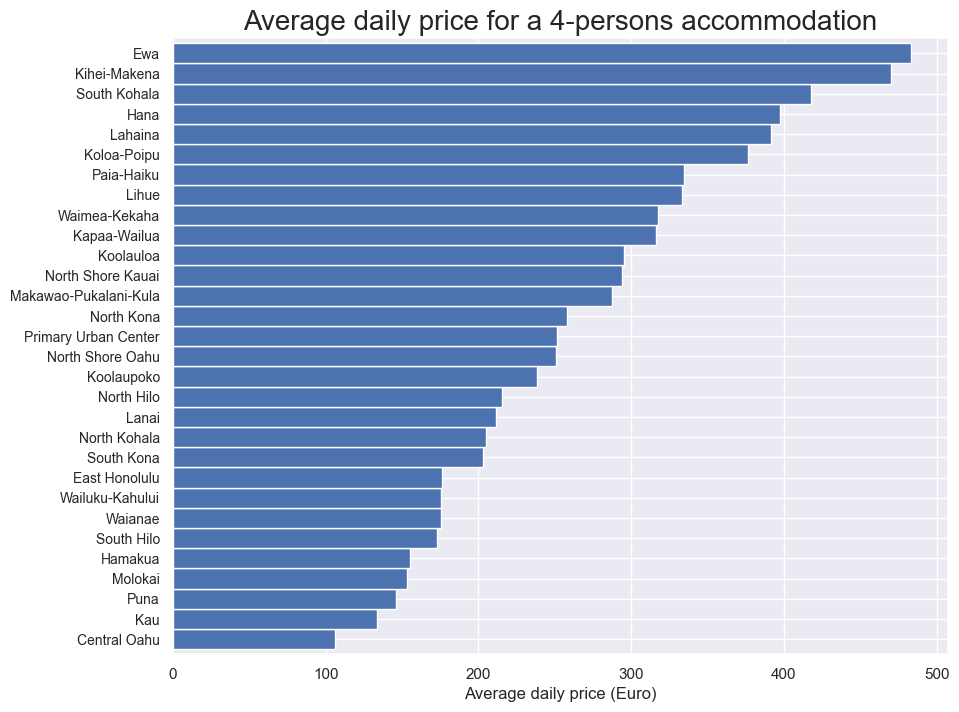

In [16]:
feq = listings[listings['accommodates']==4]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax = feq.plot.barh(figsize=(10, 8), color='b', width=1, )
plt.title("Average daily price for a 4-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
ax.tick_params(axis='y', labelsize=10)
plt.show()

A continuación puede encontrar los barrios en un mapa. Este mapa es **interactivo**. Al pasar el cursor sobre los polígonos se muestra el nombre del barrio y el precio medio de los alojamientos para 2 personas.

In [17]:
import folium
from folium import plugins
from branca.colormap import linear

In [18]:
adam = gpd.read_file("neighbourhoods.geojson")
feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

In [19]:

threshold_scale = [0, 50, 100, 150, 200, 250, 300]
colors = linear.YlOrRd_09.scale(0, 300).to_step(len(threshold_scale) - 1)

def get_color(feature):
    value = feature['properties']['average_price']
    if value is None:
        return '#8c8c8c'
    return colors(value)

map3 = folium.Map(location=[20.7967, -156.3319], zoom_start=8)

folium.GeoJson(
    adam,
    name='neighbourhoods',
    tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'], labels=True, sticky=False),
    style_function=lambda feature: {
        'fillColor': get_color(feature),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.5,
    },
    highlight_function=lambda feature: {'weight': 3, 'fillColor': get_color(feature), 'fillOpacity': 0.8},
).add_to(map3)

map3
#map3.save("map3.html")

## 4.2 Seguridad del vecindario

Como no hay datos sobre la seguridad del vecindario en los archivos de Airbnb, Hemos creído importante tener en cuenta el mapa de los peligros volcánicos en la isla de Hawaii.


<center><img src="https://static.temblor.net/wp-content/uploads/2018/05/hawaii-sp-7.jpg" style="width: 800px;"/></center>

## 4.3 Review scores location, and location scores versus price

El cuadro presentado contiene dos gráficos de barras horizontales:

Puntaje Promedio de Revisión de Ubicación por Vecindario (con al menos 10 revisiones):

Vecindarios con Mejor Puntaje: Los vecindarios como Lanai, Makawao-Pukalani-Kula y Hana tienen los puntajes más altos en las revisiones de ubicación, todos cercanos al puntaje máximo de 5.
        
Vecindarios con Menor Puntaje: Vecindarios como Waianae y Wailuku-Kahului tienen puntajes más bajos en comparación con otros, aunque siguen estando cerca de 4, lo que indica una valoración generalmente positiva.

Precio Promedio Diario para un Alojamiento de 2 Personas por Vecindario:

Vecindarios Más Caros: Koloa-Poipu, South Kohala y Lahaina son los vecindarios con los precios promedio diarios más altos, superando los 400 euros por día.

Vecindarios Más Económicos: East Honolulu, Central Oahu y Kau tienen precios significativamente más bajos, con precios promedio diarios que no superan los 100 euros.

Según este gráfico podemos destacar:
Correlación entre Puntaje y Precio: No parece haber una correlación directa y fuerte entre el puntaje de revisión de ubicación y el precio promedio diario. Algunos vecindarios con puntajes altos tienen precios altos, pero también hay vecindarios con puntajes altos y precios más bajos.

Preferencias del Cliente: Los turistas parecen valorar altamente la mayoría de las ubicaciones en Hawaii, con puntajes de revisión promedio por encima de 4 para todos los vecindarios considerados.

Recomendaciones: Para los turistas que buscan una buena relación calidad-precio, considerar vecindarios con puntajes de revisión altos pero precios más moderados puede ser una estrategia efectiva. Vecindarios como Makawao-Pukalani-Kula y North Shore Kauai pueden ofrecer un buen equilibrio entre calidad de ubicación y costo.

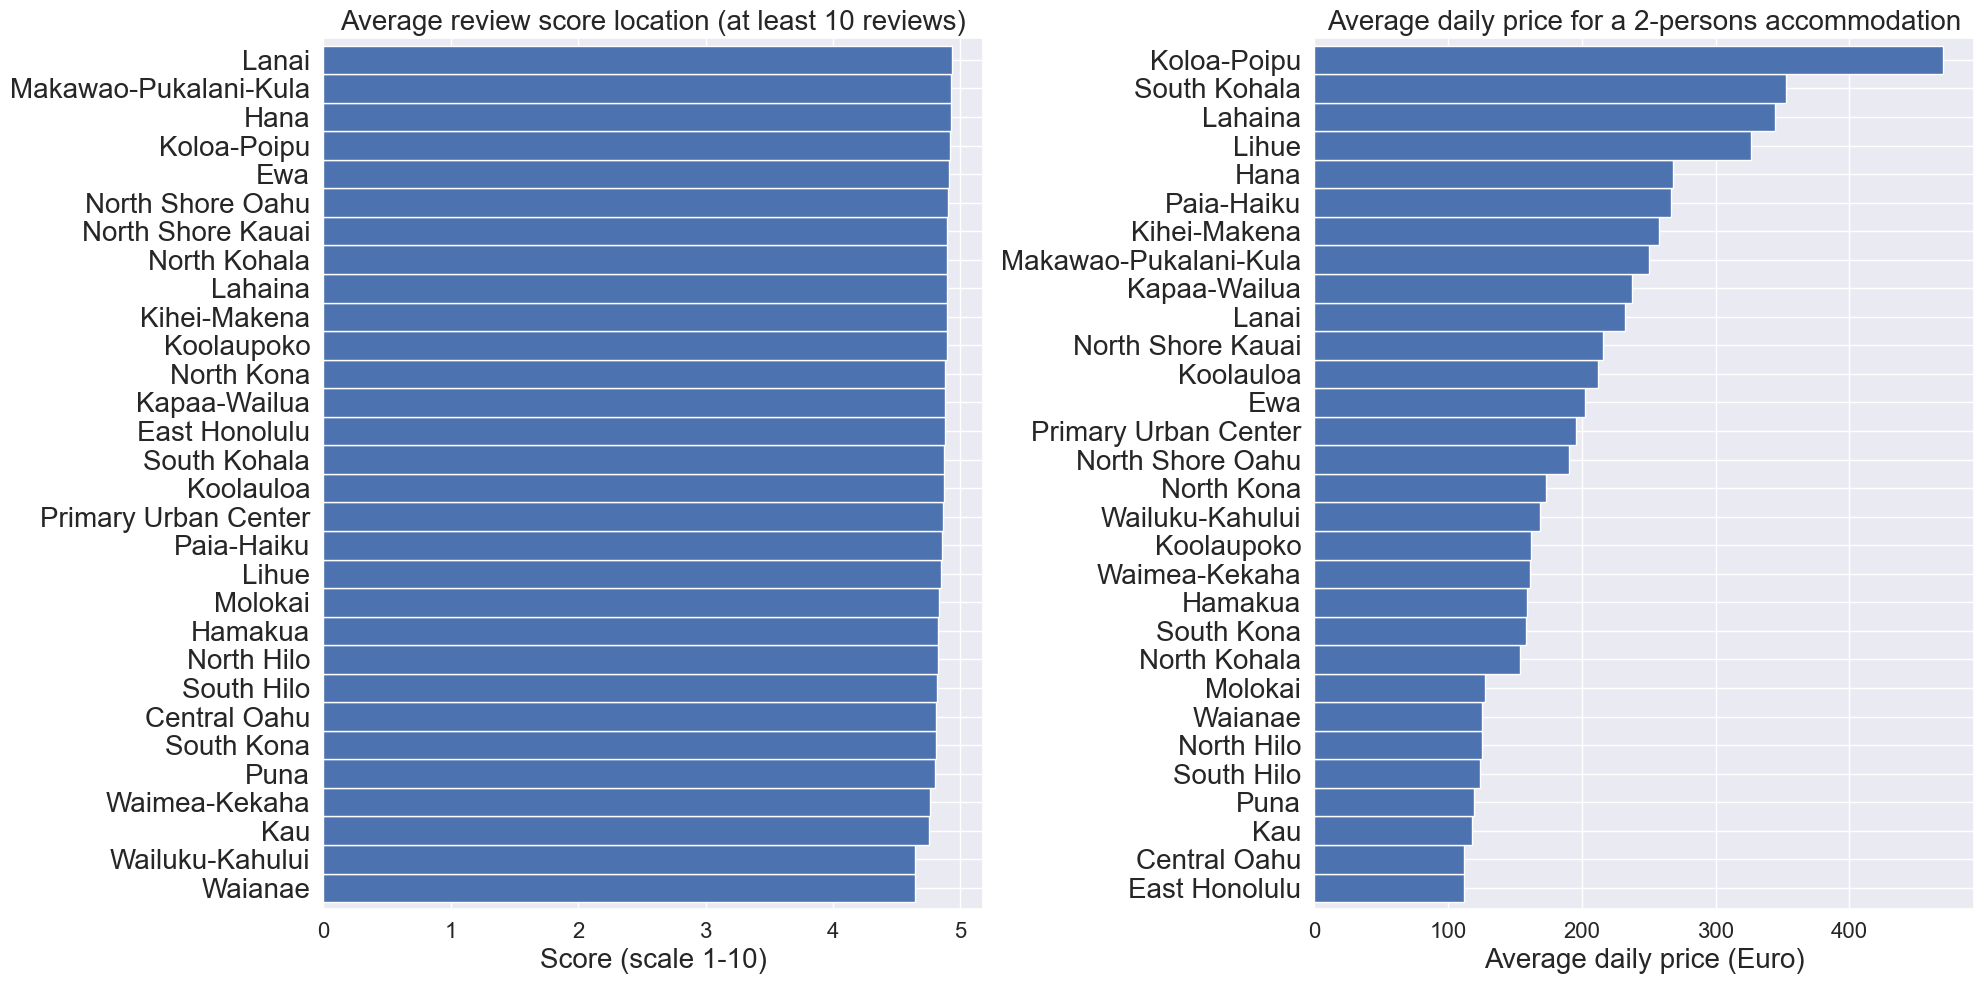

In [20]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

## 4.4 Cómo usar las puntuaciones de las opiniones

Además de las reseñas escritas, los invitados pueden enviar una calificación de estrellas general y un conjunto de calificaciones de estrellas de categoría. Los huéspedes pueden dar calificaciones sobre:

* Experiencia general. ¿Cuál fue su experiencia en general?
* Limpieza. ¿Sentiste que tu espacio estaba limpio y ordenado?
* Precisión. ¿Con qué precisión su página de listado representó su espacio?
* Valor. ¿Sintió que su listado proporcionó un buen valor por el precio?
* Comunicación. ¿Qué tan bien se comunicó con su anfitrión antes y durante su estadía?
* Llegada. ¿Qué tan bien fue su registro?
* Ubicación. ¿Cómo te sentiste en el barrio?

A continuación puede ver la distribución de puntajes de todas esas categorías. ¡Lo que me llamó la atención de inmediato es que las puntuaciones parecen realmente altas en todos los ámbitos!. Está bien explicado en este artículo: [¿Más alta que la calificación promedio? El 95 % de los listados de Airbnb calificaron de 4,5 a 5 estrellas](https://mashable.com/2015/02/25/airbnb-reviews-above-average/?europe=true#1YLfzOC34sqd).

Después de haber visto las distribuciones de puntajes, personalmente consideraría que cualquier puntaje de 8 o inferior no es un buen puntaje.

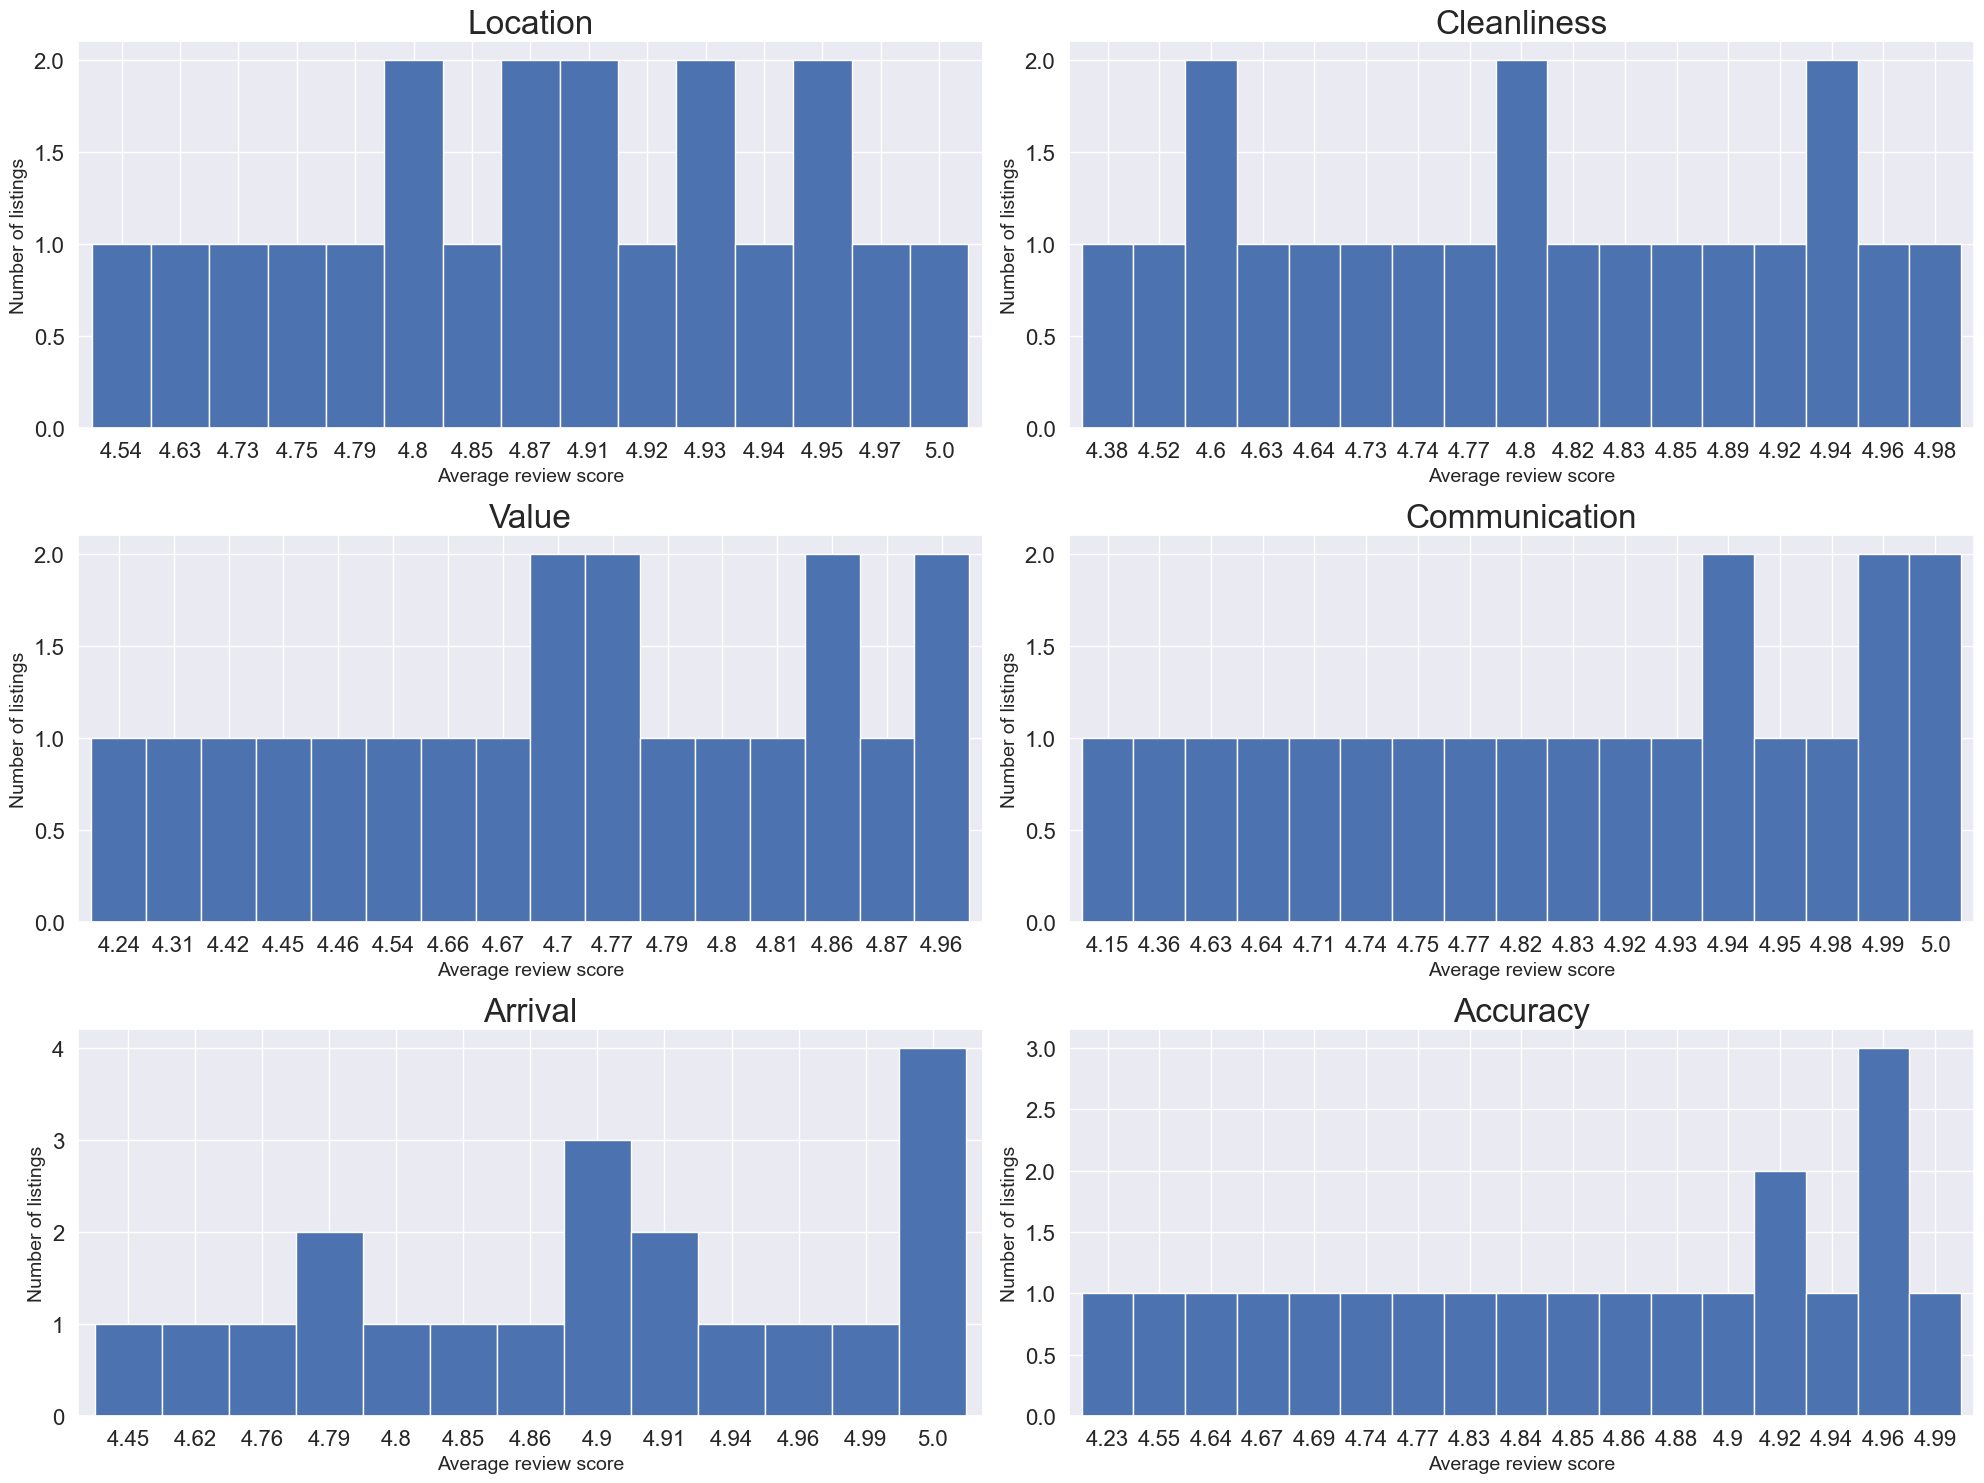

In [21]:
listings10 = listings[listings['number_of_reviews']>=10]



fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].head(20).value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].head(20).value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].head(20).value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].head(20).value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].head(20).value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].head(20).value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()

## 4.5 Encontrando un buen hospedador

En Airbnb puedes obtener el estatus de "Superhost". De Airbnb:
* Como SuperAnfitrión, tendrá más visibilidad, potencial de ingresos y recompensas exclusivas. Es nuestra manera de decir gracias por su hospitalidad excepcional.
* Cómo convertirse en Superhost: cada 3 meses, verificamos si cumple con los siguientes criterios. Si lo haces, ganarás o mantendrás tu estatus de SuperAnfitrión.
    * Los Superanfitriones tienen una calificación general promedio de 4.8 o superior según las reseñas de al menos el 50 % de sus huéspedes de Airbnb durante el último año.
    * Los Superhosts han alojado al menos 10 estadías en el último año o, si realizan reservas a más largo plazo, 100 noches en al menos 3 estadías.
    * Los Superhosts no tienen cancelaciones en el último año, a menos que haya circunstancias atenuantes.
    * Los Superhosts responden al 90 % de los mensajes nuevos en 24 horas.

A continuación, podemos ver que solo una pequeña parte de los listados en Hawaii tienen un anfitrión que es Superanfitrión.

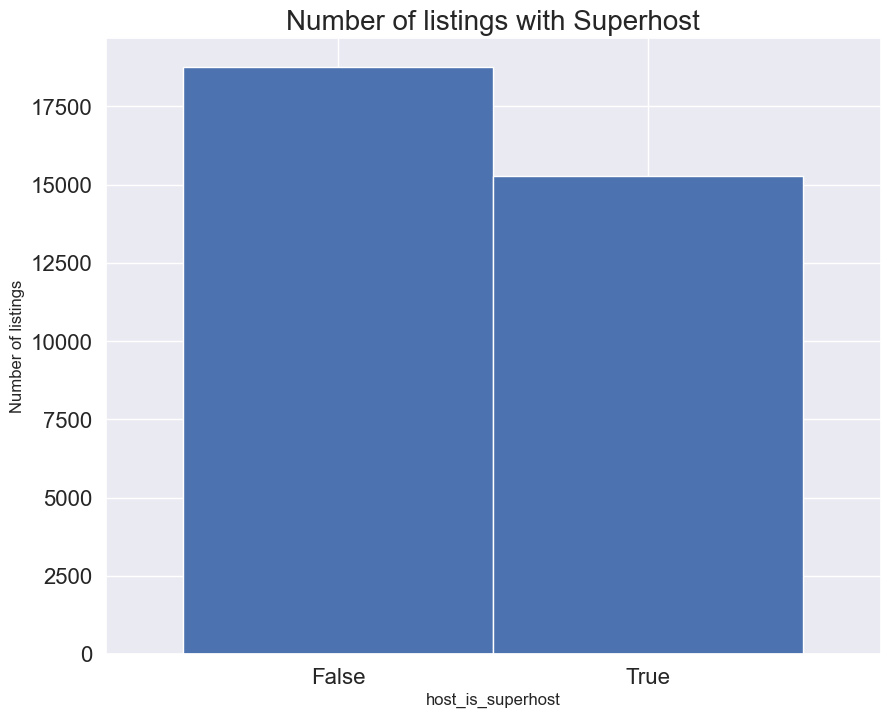

In [22]:
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})

feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

El gráfico muestra que hay más listados sin la designación de Superhost que con ella. Esto significa que, aunque los Superhosts son numerosos, la mayoría de los listados no pertenecen a Superhosts.

Aunque reservar con un Superhost puede ofrecer una experiencia más confiable y de mayor calidad, no hay que descuidar los listados sin la designación de Superhost, ya que también pueden ofrecer excelentes experiencias. debemos revisar las reseñas y puntuaciones detenidamente antes de tomar una decisión.

En resumen, optar por un Superhost en Hawaii puede aumentar la probabilidad de una experiencia satisfactoria y sin contratiempos, pero siempre es importante evaluar todos los factores, incluyendo el precio, la disponibilidad y las necesidades específicas del viaje.

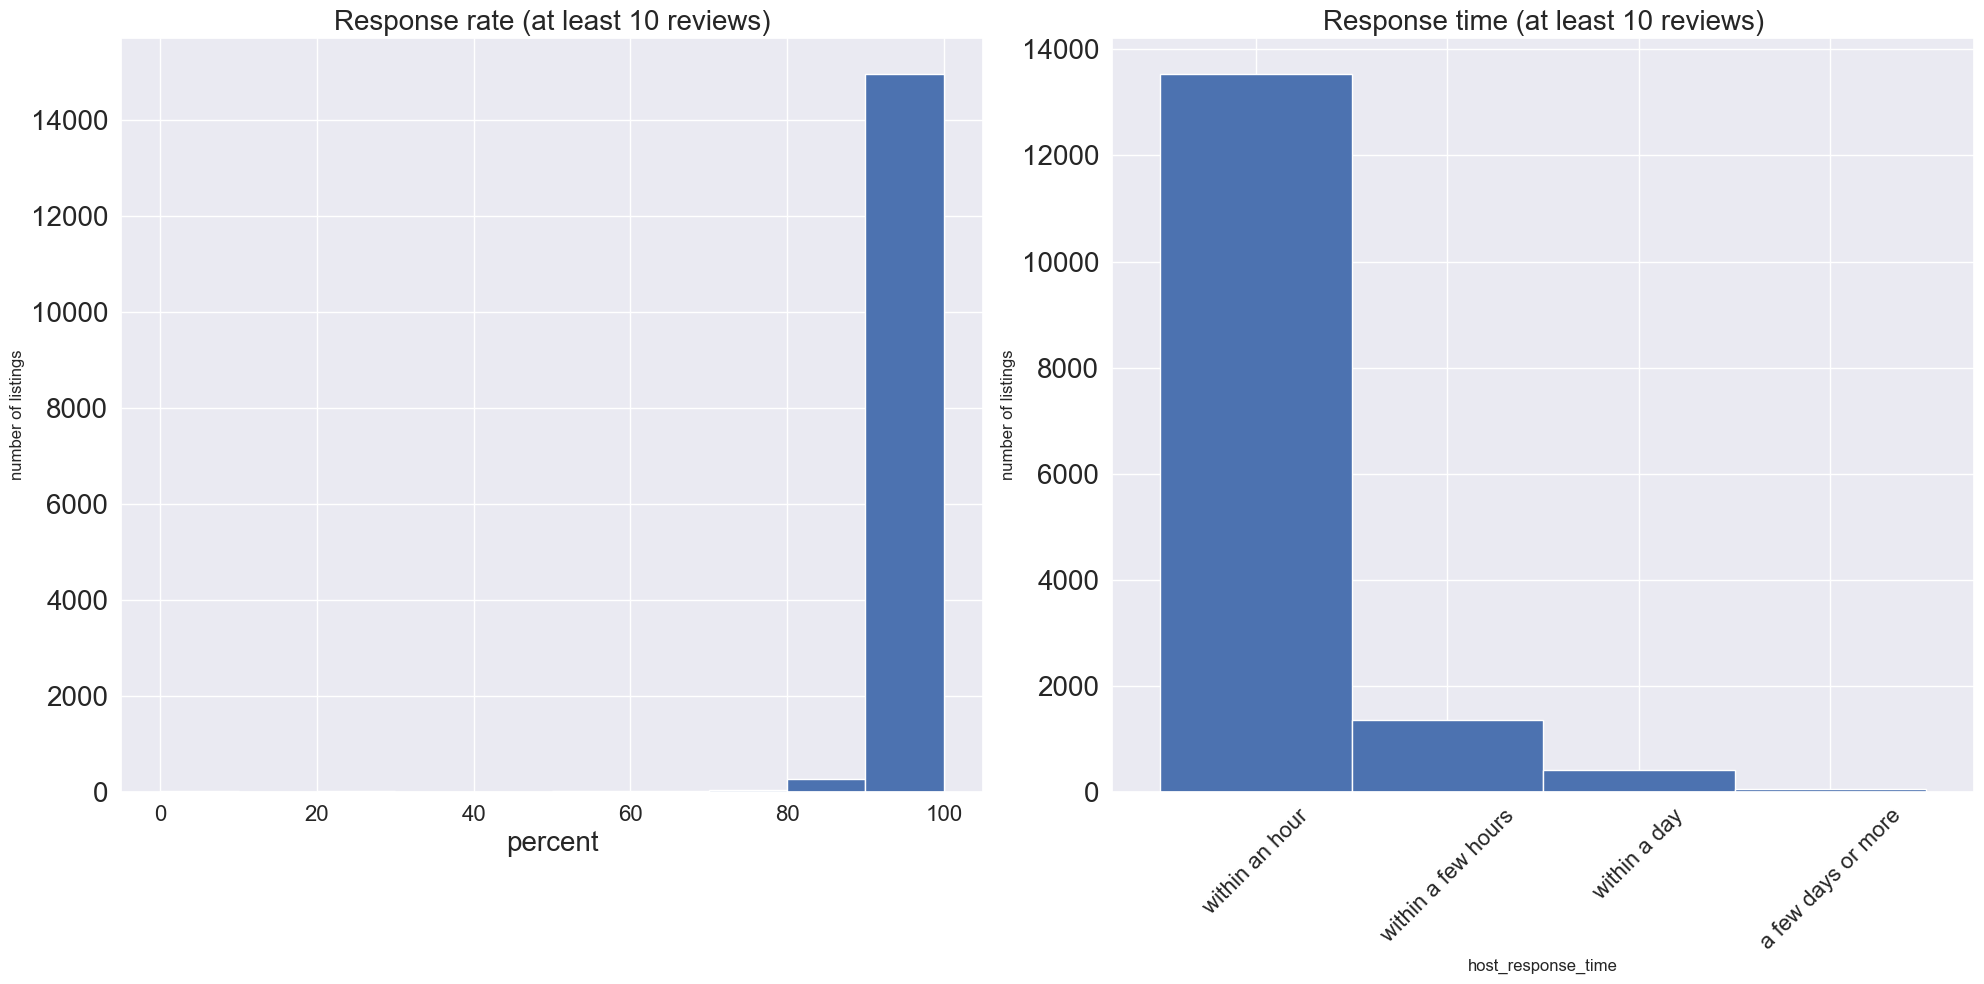

In [23]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

## GRÁFICO DE VIOLÍN:

A continuación mostramos un gráfico de violín donde podemos observar el precio y las diferentes islas. Hemos quitado los ouliers para una mejor visualización de los datos. 

En los violines podemos ver cómo las partes más anchas indican rangos de precios donde hay una mayor concentración de datos, mientras que las partes más estrechas indican rangos con menor concentración

Kauai : La distribución de precios en Kauai tiene una forma uniforme con una gran cantidad de concentrados preciosas niveles en bajos (alrededor de 0 a 200). Hay una dispersión significativa de precios hacia el extremo superior (alrededor de 800).

Honolulu: La distribución de precios en Honolulu tiene un pico muy definido alrededor de los 800, lo que indica una alta concentración de precios en ese rango. La parte más baja tiene una menor concentración.

Maui: Similar a Kauai, Maui también tiene una distribución bastante amplia con una alta concentración de precios bajos. La dispersión es menor en comparación con Kauai.

Hawai: La distribución en Hawaii muestra una concentración de precios baja más clara y se dispersa gradualmente hacia precios más altos, con un pico notable alrededor de 800.

In [24]:
import plotly.express as px

# fue necesario sacar los outliers para poder visualizar mejor la distribución
Q1 = listings_copy['price'].quantile(0.25)
Q3 = listings_copy['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
listings_filtered = listings_copy[(listings_copy['price'] >= lower_bound) & (listings_copy['price'] <= upper_bound)]


In [33]:
fig = px.violin(listings_filtered, 
                x='neighbourhood_group', 
                y='price', 
                title='Distribución del Precio por Grupos de Vecindario',
                labels={'neighbourhood_group': 'Grupo de Vecindario', 'price': 'Precio'}
               )

fig.show()
#fig.write_html("precio_vecindario.html")

## GRÁFICO DE CAJAS:

A continuación se muestra un gráfico de cajas donde visualiza la relación entre el precio y el tipo de habitación (room type) en diferentes grupos de vecindarios (neighbourhood groups). 

Podemos observar que existe una gran variabilidad en los precios dentro de cada grupo de vecindario.

En el vecindario de Kauai, se observa un precio muy alto para una "Private room" (habitación privada) en comparación con los otros tipos de habitaciones.

En general, parece que las "Entire home/apt" (casas/apartamentos enteros) y "Private room" (habitaciones privadas) dominan el número de listados en todos los vecindarios.

In [32]:
fig = px.box(listings_filtered[(listings_filtered['accommodates']==4) & (listings_filtered['price'] <=1100)],
                    x='neighbourhood_group',
                    y='price',
                    color='room_type',
                    #points="all",
                    title='Precio por Tipo de Habitación y Grupo de Vecindario',
                    labels={'neighbourhood_group': 'Grupo de Vecindario', 'price': 'Precio', 'room_type': 'Tipo de Habitación'})
fig.show()
#fig.write_html("precio_habitacion_vecindario_box.html")

In [31]:

sampled_data = listings_filtered[(listings_filtered['accommodates'] == 4) & (listings_filtered['price'] <= 1100)].sample(500)

fig = px.strip(
    sampled_data,
    x='neighbourhood_group',
    y='price',
    color='room_type',
    title='Precio por Tipo de Habitación y Grupo de Vecindario',
    labels={'neighbourhood_group': 'Grupo de Vecindario', 'price': 'Precio'},
    hover_data=['price', 'room_type'],
    stripmode='overlay'
)

# Ajustar la posición de la leyenda
fig.update_layout(
    legend_title_text='Tipo de Habitación',
    legend=dict(
        x=1.05,
        y=1,
        traceorder='normal',
        font=dict(
            size=12,
        ),
    )
)


fig.show()
#fig.write_html("precio_habitacion_vecindario_swarmplot.html")

## 4.6 Disponibilidad en el tiempo

El archivo de calendario contiene 365 registros para cada listado, lo que significa que para cada listado, el precio y la disponibilidad por fecha se especifican con 365 días de anticipación.

In [ ]:
calendar

date available    price adjusted_price  \
listing_id                                                         
5269                2024-03-22         t  $185.00            NaN   
5269                2024-03-23         t  $185.00            NaN   
5269                2024-03-24         t  $185.00            NaN   
5269                2024-03-25         f  $185.00            NaN   
5269                2024-03-26         f  $185.00            NaN   
...                        ...       ...      ...            ...   
1116378053579199504 2025-03-17         f  $170.00            NaN   
1116378053579199504 2025-03-18         f  $170.00            NaN   
1116378053579199504 2025-03-19         f  $170.00            NaN   
1116378053579199504 2025-03-20         f  $170.00            NaN   
1116378053579199504 2025-03-21         f  $170.00            NaN   

                     minimum_nights  maximum_nights  
listing_id                                           
5269                            4.0          1125.0  
5269                            4.0          1125.0  
5269                            4.0          1125.0  
5269                            5.0          1125.0  
5269                            5.0          1125.0  
...                             ...             ...  
1116378053579199504            30.0           365.0  
1116378053579199504            30.0           365.0  
1116378053579199504            30.0           365.0  
1116378053579199504            30.0           365.0  
1116378053579199504            30.0           365.0  

[12426106 rows x 6 columns]

In [ ]:
calendar = calendar.drop(columns=['adjusted_price'])
calendar = calendar.dropna(how='any')
calendar['price'] = calendar['price'].str.replace(",","").str.replace("$","")
calendar['price'] = calendar['price'].astype(float)

In [ ]:
print(calendar.shape)

(12426102, 5)


In [ ]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

date available   price  minimum_nights  \
listing_id                                                        
774610321893574872 2024-07-19         t  1999.0             3.0   
970968696084466456 2025-02-21         f    99.0            30.0   
29239107           2024-07-28         t   539.0             3.0   
934187760627365957 2025-02-08         t   183.0             2.0   
827556976725168862 2025-02-27         t   225.0             4.0   
940143662986853498 2025-01-03         f   349.0             1.0   
797037585782604010 2024-04-04         t   125.0             2.0   
935796             2025-02-11         f   144.0            30.0   
31408410           2025-01-29         t   215.0             3.0   
681807402448851902 2024-07-10         t   266.0             1.0   
963084259519224343 2025-03-01         t   801.0             3.0   
29166543           2024-05-24         f   258.0             2.0   
54050141           2025-03-12         t   630.0            30.0   
34515055           2024-10-13         t   400.0             5.0   
16300032           2024-10-02         t   180.0             1.0   

                    maximum_nights  accommodates  
listing_id                                        
774610321893574872            46.0             6  
970968696084466456           365.0             2  
29239107                    1125.0             6  
934187760627365957            27.0             4  
827556976725168862          1125.0             6  
940143662986853498           365.0             5  
797037585782604010          1125.0             4  
935796                      1125.0             2  
31408410                    1125.0             2  
681807402448851902             2.0             8  
963084259519224343            90.0             6  
29166543                    1125.0             4  
54050141                    1125.0             8  
34515055                    1125.0             4  
16300032                      29.0             7

In [ ]:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')


In [ ]:
import plotly.express as px
fig = px.line(
    sum_available.reset_index(),
    x='date',
    y='available',
    title='Number of listings available by date',
    labels={'date': 'Date', 'available': 'Number of listings available'},
    color_discrete_sequence=['blue']
)

fig.show()
#fig.write_html("listings_available_by_date.html")

## 4.7 Precio medio por día

A continuación, verá el precio promedio de todos los alojamientos para 2 personas marcados como disponibles por fecha. 

Durante la mayor parte del período (desde mayo de 2024 hasta marzo de 2025), los precios del alojamiento se mantienen relativamente estables, con pequeñas fluctuaciones. Los precios están generalmente alrededor de los 200-400 dólares, con variaciones menores que muestran ligeras subidas y bajadas.

Hacia el final del período, específicamente en marzo de 2025, hay un aumento abrupto y significativo en el precio promedio, que sube rápidamente hasta más de 800 dólares.
Después de este pico, el precio cae igualmente rápido.

Las pequeñas fluctuaciones a lo largo del tiempo pueden ser atribuibles a la variabilidad normal en la oferta y demanda del mercado de alojamiento. 
El aumento repentino en marzo de 2025 podría ser debido a un evento especial o una circunstancia extraordinaria que incrementó temporalmente la demanda de alojamiento.

 Este gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el precio promedio y el día de la semana por fecha.

In [ ]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12426102 entries, 5269 to 1116378053579199504
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   available       object        
 2   price           float64       
 3   minimum_nights  float64       
 4   maximum_nights  float64       
 5   accommodates    int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 663.6+ MB


In [ ]:
filtered_calendar = calendar[(calendar['available'] == "t") & (calendar['accommodates'] == 2)]
average_price = filtered_calendar.groupby('date')['price'].mean().reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

fig = px.line(
    average_price.reset_index(),
    x='date',
    y='price',
    title='Average price of available 2 persons accommodation by date',
    labels={'date': 'Date', 'price': 'Average price of available 2 persons accommodation'},
    color_discrete_sequence=['blue'])
fig.show()
#fig.write_html("Average_Price_2_persons.html")

# 5. Minería de texto con las reviews

Veamos ahora cómo podríamos obtener algo de información extra de las opiniones de los usuarios, en términos muy elementales. Esta sección es un preliminar muy introductorio y básico de un amplio área de estudio conocida como *topic modelling*.

El archivo de "reviews" resultó no ser muy interesante, ya que solo contiene fechas de revisión para cada listado, lo que significa que solo es bueno para contar el número de revisiones. El archivo "reviews_details" contiene la misma información (y la misma cantidad de registros), con 4 columnas adicionales. Además, fusionamos host_id y host_names de la lista con el archivo reviews_details.

In [ ]:
reviews_details.shape

(1195681, 6)

In [ ]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

listing_id                                       name  host_id  \
id                                                                          
289800           5269  Upcountry Hospitality in the 'Auwai Suite     7620   
742885           5269  Upcountry Hospitality in the 'Auwai Suite     7620   
494178707        5269  Upcountry Hospitality in the 'Auwai Suite     7620   
523932651        5269  Upcountry Hospitality in the 'Auwai Suite     7620   
536049410        5269  Upcountry Hospitality in the 'Auwai Suite     7620   

           host_name       date  reviewer_id reviewer_name  \
id                                                           
289800     Lea & Pat 2011-05-31       452192          Gert   
742885     Lea & Pat 2011-11-25      1135109          Lene   
494178707  Lea & Pat 2019-07-23    131185347      Kathleen   
523932651  Lea & Pat 2019-09-04      5708075        Martha   
536049410  Lea & Pat 2019-09-25     85727419         Brent   

                                                    comments  
id                                                            
289800     Very warm welcome. Great place to stay.  Highl...  
742885     Barrie was very kind and sweet but it could no...  
494178707  Great place, location & wonderful hostess. Tha...  
523932651  This is such a charming and cozy place to stay...  
536049410  Cute little place with easy access to Waimea a...

In [ ]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

number_of_reviews
host_id   host_name                                  
5786717   Viktoria                               9439
113441705 My Perfect Stays                       8235
43793840  Mark                                   8048
111808435 Vacasa                                 6496
15820446  Maui Paradise Properties               5050

In [ ]:
reviews_details.comments.head()

id
289800       Very warm welcome. Great place to stay.  Highl...
742885       Barrie was very kind and sweet but it could no...
494178707    Great place, location & wonderful hostess. Tha...
523932651    This is such a charming and cozy place to stay...
536049410    Cute little place with easy access to Waimea a...
Name: comments, dtype: object

In [ ]:
reviews_details.comments.values[2] #print comment with numbers and windows line break

'Great place, location & wonderful hostess. Thanks for a great stay'

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#take out empty comments (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

'great place, location & wonderful hostess. thanks great stay'

In [ ]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

words  counts
2         great  730178
3         place  648066
4          stay  616871
223          br  481821
32     location  453615
145       beach  453318
128       clean  305584
232       would  295086
108  everything  270923
125        nice  235221

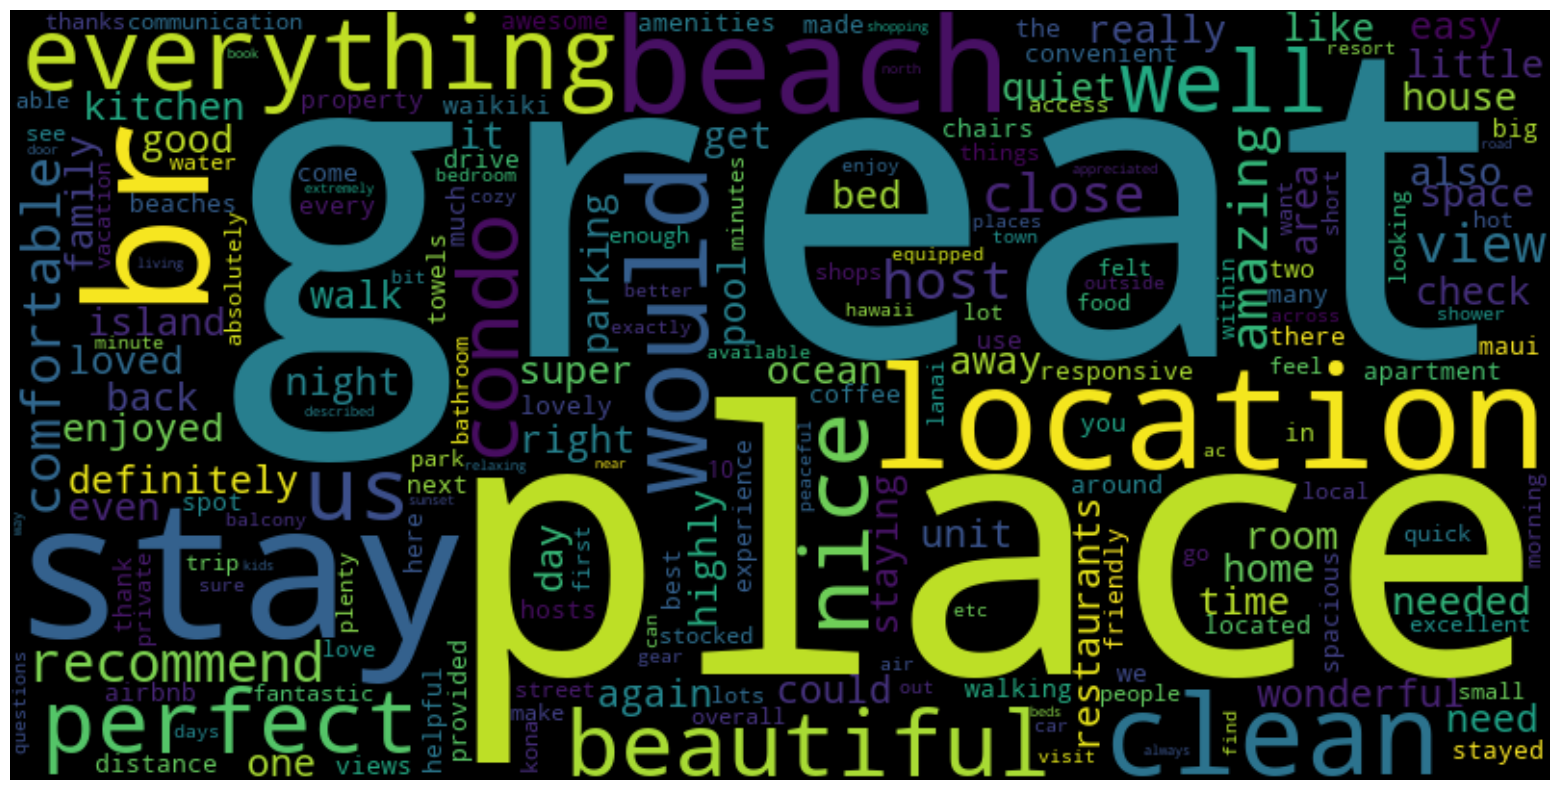

In [ ]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()